# **CAP-417: Estatística Computacional (Computational Statistics)**

<img src="https://raw.githubusercontent.com/vsantjr/CAP/master/Images/thedice.jpg" alt="Drawing" width="350"/>

<br>

# ***Gaussian Mixture Models***
-----

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<br>

Some modifications and additions were developed by Prof. <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a> for the Computational Statistics CAP course at INPE</a>. However, if you want to cite this material, particularly the parts more related to Gaussian Mixture Models, **please cite the book [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas**.


<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

# Gaussian Mixture Models
----

In this notebook, we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html">*k*-means clustering algorithm</a>, but can also be a powerful tool for **estimation beyond simple clustering**.



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means
----

Let us take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model. Given simple, well-separated data, *k*-means finds suitable clustering results.

For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye.

Question: How can we define the best value of k?

In [ ]:
# Generate some data
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

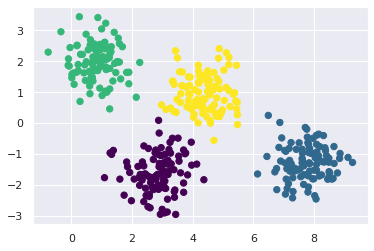

In [ ]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0) # Change to 3 and 5
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has **no intrinsic measure of probability or uncertainty** of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalising the model.

One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualise this cluster model with the following function.

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

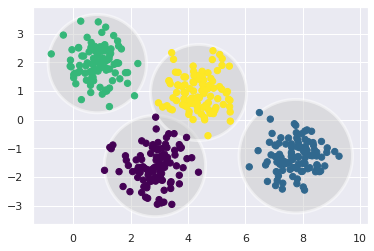

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models **must be circular**: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled.

**PS**: According to <a href="https://numpy.org/doc/stable/reference/random/legacy.html#numpy.random.RandomState">numpy</a>: 

"RandomState and Generator expose a number of methods for generating random numbers drawn from a variety of probability distributions. In addition to the distribution-specific arguments, each method takes a keyword argument size that defaults to None. If size is None, then a single value is generated and returned. If size is an integer, then a 1-D array filled with generated values is returned. If size is a tuple, then an array with that shape is filled and returned."

X dimension (row x columns):  (400, 2)
Sample (or samples) from the “standard normal” distribution [[-0.71239066  0.75376638]
 [-0.04450308  0.45181234]]


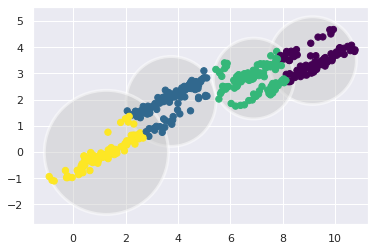

In [ ]:
rng = np.random.RandomState(13)
print('X dimension (row x columns): ', X.shape)
print('Sample (or samples) from the “standard normal” distribution', rng.randn(2, 2))
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

We can perceive that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap.

These disadvantages of *k*-means, its lack of flexibility in cluster shape and lack of probabilistic cluster assignment, mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

We can think about generalising the *k*-means model: for example, we could measure **uncertainty** in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, the **Gaussian mixture models** (GMMs).

## Generalising E–M: Gaussian Mixture Models
----

A GMM attempts to find a mixture of multi-dimensional **Normal (Gaussian) probability distributions** that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means.

These are the labels: 
 [3 2 2 3 2 1 0 3 2 0 1 0 3 2 2 0 2 0 3 2 2 2 1 3 3 1 1 3 3 0 3 3 2 3 2 1 0
 3 0 3 2 1 0 3 0 1 0 0 0 1 1 1 2 1 1 2 3 0 0 2 0 0 0 0 3 2 0 3 2 1 2 3 2 1
 0 2 3 2 1 2 2 3 0 1 3 2 2 3 2 0 2 0 3 2 2 1 3 0 0 0 1 0 3 3 2 1 3 1 0 2 2
 2 3 2 1 0 1 2 1 1 0 2 0 1 3 1 0 0 0 3 1 1 1 2 3 2 1 3 1 2 3 2 2 1 2 0 3 2
 0 2 0 3 0 3 1 2 0 2 2 2 3 2 1 2 2 1 0 0 2 1 1 1 1 0 0 0 3 2 3 1 3 1 2 3 1
 2 1 3 3 1 3 3 1 2 1 1 1 0 0 3 3 2 0 0 1 3 2 1 3 1 3 3 0 0 1 0 3 1 0 1 2 3
 1 2 2 2 0 1 3 1 3 2 3 3 1 0 2 0 3 2 0 3 3 1 0 3 1 3 0 2 2 0 2 3 1 1 3 3 0
 1 3 2 2 2 1 3 3 3 3 3 0 3 3 1 2 0 1 0 0 0 1 0 0 1 1 1 0 3 0 3 0 2 3 0 2 3
 0 0 3 2 1 1 3 1 0 0 3 1 1 0 0 3 1 3 0 3 0 1 2 2 0 2 3 2 2 1 2 1 0 2 1 0 1
 3 2 3 2 0 3 0 1 0 0 0 0 1 0 2 0 2 0 3 1 2 0 0 3 2 2 1 1 1 2 3 0 3 2 0 2 1
 2 3 3 2 1 3 1 1 2 1 2 1 3 3 3 2 1 1 1 1 2 1 3 0 0 3 3 0 3 0]
There are 400 labels!


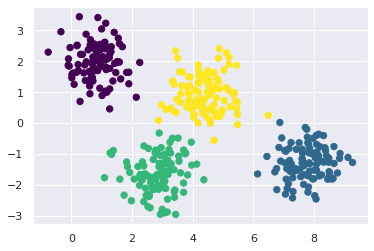

In [ ]:
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
# c: array-like or list of colors or color. We use the labels!
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
print('These are the labels: \n', labels)
print('There are {} labels!'.format(len(labels)))

From <a href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html">scikit-learn</a>, some remarks:

"Gaussian Mixture: Representation of a Gaussian mixture model probability distribution. This class allows to estimate the parameters of a Gaussian mixture distribution".

```class sklearn.mixture.GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)```

Parameters (some):

```
n_components int, default=1
The number of mixture components.


covariance_type{‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
String describing the type of covariance parameters to use. Must be one of:
‘full’: each component has its own general covariance matrix.

‘tied’: all components share the same general covariance matrix.

‘diag’: each component has its own diagonal covariance matrix.

‘spherical’: each component has its own single variance.
```

















## Covariance
----

In probability theory and statistics, covariance is a measure of the joint variability of two random variables. In other words, covariance meausures how much two random variables vary together. It is similar to variance, but where variance indicates how a single variable varies, covariance identifies how two variables vary together.

Covariance is given by the following formula:

$$
cov(X,Y) = E[(X – E[X]) \cdot (Y – E[Y])],
$$

where $E(X)$ and $E(Y)$ are the expected values (means) of the random variables $X$ and $Y$, respectively. 

Below, we show to calculate covariance for 1D data and compare to numpy. Regarding normalisation (```bias``` parameter), remarks from numpy:

" bias bool, optional

Default normalization (False) is by (N - 1), where N is the number of observations given (unbiased estimate). If bias is True, then normalization is by N. These values can be overridden by using the keyword ddof in numpy versions >= 1.5.
"

In [ ]:
# Covariance from scratch: 1-dimensional data

def my_covariance(x, y, bias=False):
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  s = ((x - mean_x) * (y - mean_y)).sum()  
  if not(bias):
    return s/(len(x)-1)  
  else:
    return s/(len(x))

my_X = np.array([2.1, 2.5, 3.6, 4.0])
my_Y = np.array([8, 10, 12, 14])  
normalisation = False
print('My covariance (1D): ', my_covariance(my_X, my_Y,bias=normalisation))
print('Numpy covariance (1D): ', np.cov(my_X,my_Y,bias=normalisation)[0][1])


My covariance (1D):  2.2666666666666666
Numpy covariance (1D):  2.2666666666666666


<img src="https://raw.githubusercontent.com/vsantjr/CAP/master/Images/signcovariance.png" alt="Drawing" width="150"/>

Source: <a href ="https://en.wikipedia.org/wiki/Covariance">Wikipedia</a>

<br>

But because GMM contains a **probabilistic model** under the hood, it is also possible to find probabilistic cluster assignments. In scikit-learn, this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures **the probability that any point belongs to the given cluster**.

In [ ]:
# Just checking array slicing
l = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
npoints = 3
xl = np.array(l)
print('Slicing: ', xl[:npoints])
print()

probs = gmm.predict_proba(X)
print('Prob dimension (row x columns): ', probs.shape)
npoints = 10
print('Cluster probability of the first n points: \n', probs[:npoints].round(3))

Slicing:  [2 3 4]

Prob dimension (row x columns):  (400, 4)
Cluster probability of the first n points: 
 [[0.    0.469 0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.014 0.986]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]]


Under the hood, a GMM is very similar to *k*-means: it uses an expectation–maximisation approach which qualitatively does the following:

1. Choose starting guesses for the location and shape;

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster;
   2. *M-step*: for each cluster, update its location, normalisation, and shape based on *all* data points, making use of the weights.

The result of this is that **each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model**.
Just as in the *k*-means expectation–maximisation approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initialisations are used.

The function below helps us visualise the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output.

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    #for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
     #   draw_ellipse(pos, covar, alpha=w * w_factor)
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)    

With this in place, we can take a look at what the four-component GMM gives us for our initial data (X):

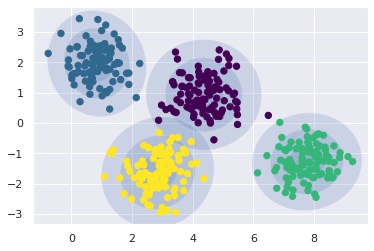

In [ ]:
#gmm = GMM(n_components=4, random_state=42)
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset. If we allow for a full covariance the model will fit even very oblong, stretched-out clusters.

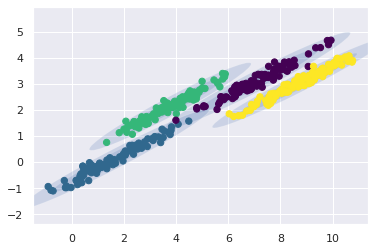

In [ ]:
#gmm = GMM(n_components=4, covariance_type='full', random_state=42)
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

## The Covariance Type

The default is ``covariance_type="diag"`` which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"`` which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"`` which allows each cluster to be modelled as an ellipse with arbitrary orientation.



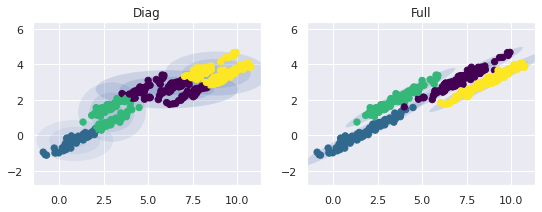

In [ ]:
plt.figure(figsize=(9, 3))

plt.subplot(121)
gmm = []
gmm = GaussianMixture(n_components=4, covariance_type='diag', random_state=42)
plot_gmm(gmm, X_stretched)
plt.title('Diag')

plt.subplot(122)
gmm = []
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)
plt.title('Full')
plt.show()


## Correlation
----

As well as covariance, **correlation** is another concept in statistics and probability theory to wonder about the relationships between random variables. Usually, in statistics correlation normally refers to the degree to which a pair of variables are **linearly** related.

What is the difference between correlation and covariance?

As shown in <a href="https://builtin.com/data-science/covariance-vs-correlation">S. Saha's post</a>:

* Covariance as well as correlation indicate the direction of the linear relationship between variables;
* Correlation values are standardised;
* Covariance values are not standardised.







## Pearson Correlation Coefficient 
----

Also known as **Pearson's r** or the **Pearson product-moment correlation coefficient** (PPMCC), the Pearson correlation coefficient (PCC) measures the linear correlation between two sets of data (e.g. random variables). It is basically a normalised measurement of the covariance between two random variables, so that the results are always between -1 and 1. 

When applied to a population, PCC is commonly represented by the Greek letter $\rho$ and may be referred to as the population Pearson correlation coefficient. Hence, $\rho$ is given by:

$$
\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \cdot \sigma_Y}
$$

where $X$ and $Y$ are two random variables, $\sigma_X$ and $\sigma_Y$ are the standard deviations of X and Y, respectively.

<br>

From SciPy about <a href = "https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html">PCC</a>:

"The Pearson correlation coefficient measures the linear relationship between two datasets. The calculation of the p-value relies on the assumption that each dataset is **normally distributed**. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship."

<br>

Thus, we can use the Shapiro-Wilk test to check dataset normality. From SciPy about the <a href ="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html">Shapiro-Wilk test</a>:

"The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution."

Thus, we can reject the null hypothesis if the p-value is less than or equal to a defined significance level (usually 0.05). But, in a strict manner, if $p-value > sig\_level$ we cannot say with certainty that the null hypothesis should be accepted: the null hypothesis is not rejected in this case. However, in general, we usually accept the null hypothesis when $p-value > sig\_level$.

<br>

And to generate a normal continuous random variable, we can use <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html">```scipy.stats.norm```</a> where "The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation."

Shapiro-Wilk my_X: statistic 0.9934272766113281 and p-value 0.9124480485916138 
Shapiro-Wilk my_Y: statistic 0.9839402437210083 and p-value 0.2656973600387573 

My covariance (1D):  -3.0838561118697005
Numpy covariance (1D):  -3.0838561118697

Pearson's r/rho -0.18706363802352388 and p-value 0.062377279359273126


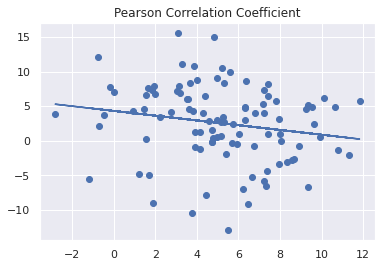

In [ ]:
import scipy.stats 

rng = np.random.default_rng()
my_X = scipy.stats.norm.rvs(loc=5, scale=3, size=100, random_state=rng)
my_Y = scipy.stats.norm.rvs(loc=2, scale=5, size=100, random_state=rng)

# Check normality of data
shap_X = scipy.stats.shapiro(my_X)
shap_Y = scipy.stats.shapiro(my_Y)

print('Shapiro-Wilk my_X: statistic {} and p-value {} '.format(shap_X[0], shap_X[1]))
print('Shapiro-Wilk my_Y: statistic {} and p-value {} '.format(shap_Y[0], shap_Y[1]))

print()
normalisation = False
print('My covariance (1D): ', my_covariance(my_X, my_Y,bias=normalisation))
print('Numpy covariance (1D): ', np.cov(my_X,my_Y,bias=normalisation)[0][1])
print()
pearson = scipy.stats.pearsonr(my_X, my_Y)
print("Pearson's r/rho {} and p-value {}".format(pearson[0],pearson[1]))

plt.figure()
a, b = np.polyfit(my_X, my_Y, 1)
plt.scatter(my_X, my_Y);
plt.title('Pearson Correlation Coefficient')
plt.plot(my_X, a*my_X+b);

## Kendall Rank Correlation Coefficient 
----

The **Kendall rank correlation coefficient** or **Kendall's $\tau$ coefficient** aims at measuring the ordinal association between two (random) variables. A $\tau$ test is a non-parametric hypothesis test for statistical dependence based on the $\tau$ coefficient.

It is then considered a non-parametric alternative to PCC when data has failed one or more of the assumptions of the PCC's test. 

In its simplest form (ties are neglected), Kendall's $\tau$ can be defined as shown below:

$$
\tau = \frac{n_c - n_d}{\binom{n}{2}},
$$

where:

*   $n_c$ = number of concordant pairs;
*   $n_d$ = number of disconcordant pairs;
*   $n$ = total number of pairs.

<br>

Above, we assume that we have a set of observations $(x_{1},y_{1}),\cdots,(x_{n},y_{n})$ of the joint random variables $X$ and $Y$, such that all the values of $x_i$ and $y_i$ are unique (no ties). Let us assume this pair of observations:

$$
(x_1, y_1) = (2,4) \quad \mbox{and} \quad (x_2, y_2) = (3, 6)
$$

This is called a *concordant* pair, since $x_1 < x_2$ and $y_1 < y_2$.

Let us assume this other pair of observations:

$$
(x_1, y_1) = (5,8) \quad \mbox{and} \quad (x_2, y_2) = (3,4)
$$

This is also called a *concordant* pair, since $x_1 > x_2$ and $y_1 > y_2$. Any other pair of observations that does not follow any of these two properties above ($x_1 < x_2$ and $y_1 < y_2$ OR $x_1 > x_2$ and $y_1 > y_2$ ) are said to be *discordant*.







There are several versions of Kendall's $\tau$ as shown below:

*   $\tau_a$ and $\tau_b$ are usually used for square tables (with equal columns and rows). $\tau_a$ does not make any adjustments for ties but $\tau_b$ does such adjustments for tied ranks. Hence, $\tau_b$ is considered an alternative to the non-parametric Spearman rank-order correlation coefficient (especially when there is a small sample size with many tied ranks);
*   $\tau_c$ is usually used for rectangular tables. 

<br>

From SciPy about <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html">Kendall's $\tau$</a>:

"Kendall’s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. This implements two variants of Kendall’s tau: **tau-b (the default)** and tau-c (also known as Stuart’s tau-c). These differ only in how they are normalized to lie within the range -1 to 1; the hypothesis tests (their p-values) are identical. Kendall’s original tau-a is not implemented separately because both tau-b and tau-c reduce to tau-a in the absence of ties."

Shapiro-Wilk my_X: statistic 0.9313881993293762 and p-value 5.9716589021263644e-05 
Shapiro-Wilk my_Y: statistic 0.9547255039215088 and p-value 0.0017219304572790861 

My covariance (1D):  56.792410842965005
Numpy covariance (1D):  56.79241084296503

Kendall's tau 0.1078787878787879 and p-value 0.1117639623197127


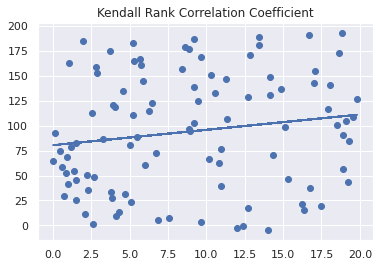

In [ ]:
my_X = np.random.uniform(low=0, high=20, size=(100,))
my_Y = 2*np.arange(0, 100) - 5

# Check normality of data
shap_X = scipy.stats.shapiro(my_X)
shap_Y = scipy.stats.shapiro(my_Y)

print('Shapiro-Wilk my_X: statistic {} and p-value {} '.format(shap_X[0], shap_X[1]))
print('Shapiro-Wilk my_Y: statistic {} and p-value {} '.format(shap_Y[0], shap_Y[1]))

print()
normalisation = False
print('My covariance (1D): ', my_covariance(my_X, my_Y,bias=normalisation))
print('Numpy covariance (1D): ', np.cov(my_X,my_Y,bias=normalisation)[0][1])
print()
kendall = scipy.stats.kendalltau(my_X, my_Y)
print("Kendall's tau {} and p-value {}".format(kendall[0],kendall[1]))

plt.figure()
a, b = np.polyfit(my_X, my_Y, 1)
plt.scatter(my_X, my_Y);
plt.title("Kendall Rank Correlation Coefficient")
plt.plot(my_X, a*my_X+b);